In [1]:
import warnings
import struct
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '../../../')
import ldcpy

%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
warnings.filterwarnings("ignore")

# display the plots in this notebook
%matplotlib inline

os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [2]:
# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html

daily_variables = [
    "TS",
    "PRECT",
    "LHFLX",
    "FLNS",
    "ICEFRAC",
    "PSL",
    "Q200",
    "TAUX",
    "WSPDSRFAV",
    "Z500"
]


def get_data(compression_type, daily_variables, compression_levels):
    data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

    climate_var_arrays = {}

    for variable in daily_variables:
        new_levels = [f"orig_{variable}"]
        new_sets = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]

        for value in compression_levels:
            if compression_type == "ZFP":
                new_level = f"zfp_p_{value}_{variable}"
                new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
            elif compression_type == "BG":
                new_level = f"bg_{value}_{variable}"
                new_set = f"{data_path}/daily_bg/bg_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"

            new_levels.append(new_level)
            new_sets.append(new_set)

        dataset = ldcpy.open_datasets("cam-fv", [f"{variable}"], new_sets, new_levels, chunks={})
        climate_var_arrays[variable] = np.array(dataset[variable].isel(time=0).values)

    return climate_var_arrays


def binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))


def get_adj_bit(bit_pos):
    return [bit_pos[0] - 1, bit_pos[1]]


def get_dict_list(data_array, x_index):
    dict_list_H = []
    for i in range(N_BITS - 1):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = binary(current_data)

            adj_data_index = get_adj_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = binary(adj_data)

            for i in range(N_BITS - 1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])

                p00 = p01 = p10 = p11 = 0
                if adjacent_bit == 0 and current_bit == 0:
                    p00 = 1
                elif adjacent_bit == 1 and current_bit == 0:
                    p10 = 1
                elif adjacent_bit == 0 and current_bit == 1:
                    p01 = 1
                elif adjacent_bit == 1 and current_bit == 1:
                    p11 = 1

                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11

    return dict_list_H


def get_mutual_info(p00, p01, p10, p11):
    p0 = p00 + p10  # current bit is 0
    p1 = p11 + p01  # current bit is 1
    p0_prev = p00 + p01  # prev bit was 0
    p1_prev = p11 + p10  # prev bit was 1

    # From (4) in paper
    # mutual information
    mutual_info = 0
    if p00 > 0:
        mutual_info += p00 * np.log2(p00 / p0_prev / p0)
    if p11 > 0:
        mutual_info += p11 * np.log2(p11 / p1_prev / p1)
    if p01 > 0:
        mutual_info += p01 * np.log2(p01 / p0_prev / p1)
    if p10 > 0:
        mutual_info += p10 * np.log2(p10 / p1_prev / p0)

    return mutual_info


def getbpe(data_array, x_index, title, compression_levels):
    dict_list_H = get_dict_list(data_array, x_index)

    # Total number of recordings. Sum all counts for first dictionary
    num_measurements = np.sum(list(dict_list_H[0].values()))

    mutual_info_array = []
    for bit_pos_dict in dict_list_H:
        p00 = np.divide(bit_pos_dict["00"], num_measurements, dtype=np.float64)
        p01 = np.divide(bit_pos_dict["01"], num_measurements, dtype=np.float64)
        p10 = np.divide(bit_pos_dict["10"], num_measurements, dtype=np.float64)
        p11 = np.divide(bit_pos_dict["11"], num_measurements, dtype=np.float64)

        mutual_info = get_mutual_info(p00, p01, p10, p11)

        mutual_info_array.append(mutual_info)

    return mutual_info_array

In [3]:
N_BITS = 32

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62

dataset size in GB 1.62



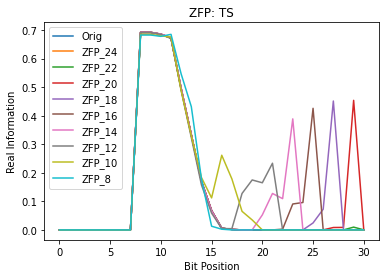

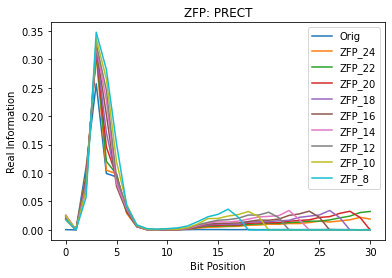

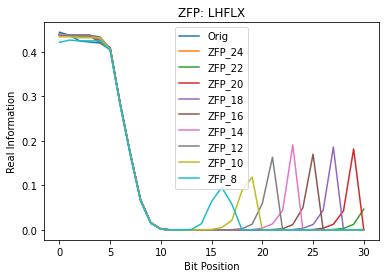

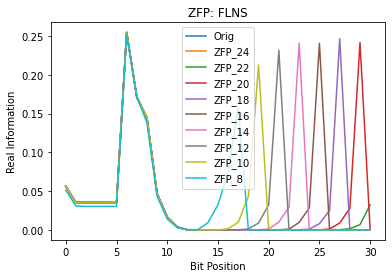

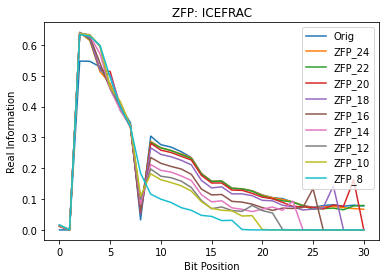

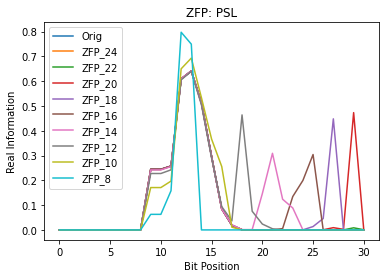

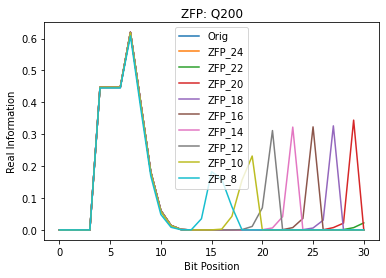

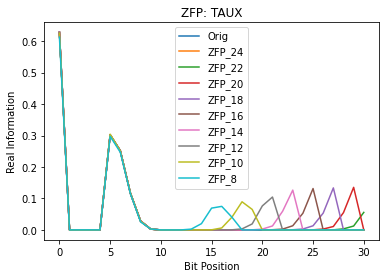

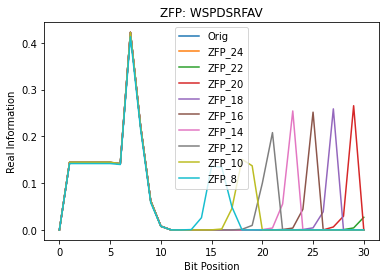

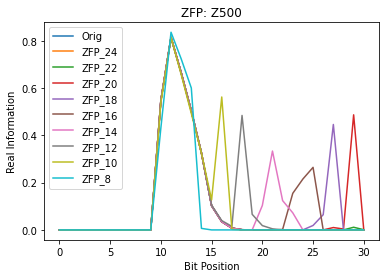

In [4]:
# ZFP
compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
zfp_climate_var_arrays = get_data("ZFP", daily_variables, compression_levels)


compression_levels = ["ZFP_" + str(x) for x in compression_levels]
compression_levels = ["Orig"] + compression_levels

for daily_variable in daily_variables:
    arr = zfp_climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        mutual_info = getbpe(arr, i, daily_variable, compression_levels)
        plt.plot(mutual_info)

    plt.title(f"ZFP: {daily_variable}")
    plt.xlabel("Bit Position")
    plt.ylabel("Real Information")
    plt.legend(compression_levels)
    plt.show()

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13

dataset size in GB 1.13



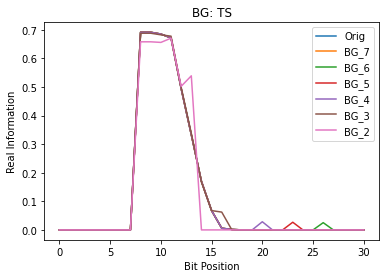

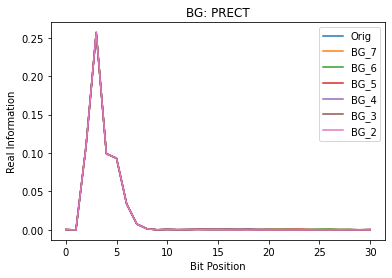

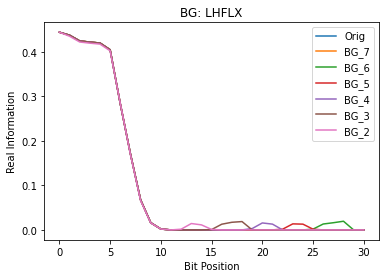

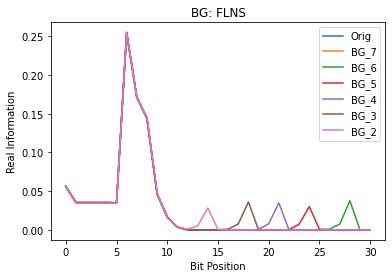

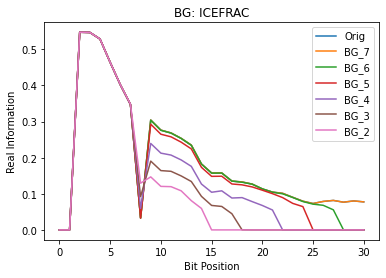

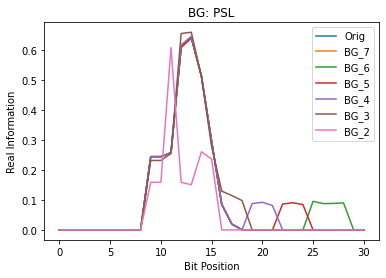

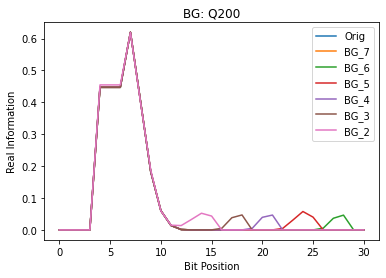

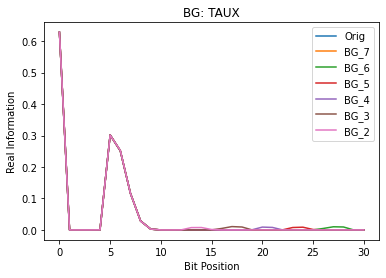

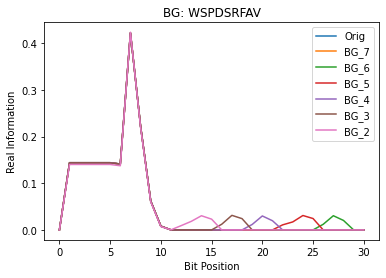

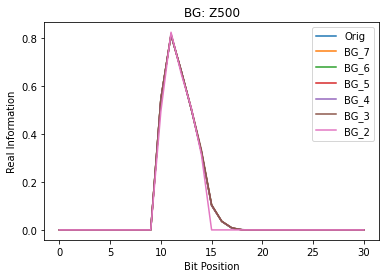

In [5]:
# BG
compression_levels = [7, 6, 5, 4, 3, 2]

bg_climate_var_arrays = get_data("BG", daily_variables, compression_levels)


compression_levels = ["BG_" + str(x) for x in compression_levels]
compression_levels = ["Orig"] + compression_levels

for daily_variable in daily_variables:
    arr = bg_climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        mutual_info = getbpe(arr, i, daily_variable, compression_levels)
        plt.plot(mutual_info)

    plt.title(f"BG: {daily_variable}")
    plt.xlabel("Bit Position")
    plt.ylabel("Real Information")
    plt.legend(compression_levels)
    plt.show()